
<div dir=ltr align=center>

# Gaussian Mixture Model - Customer Segmentation

**Machine Learning - Computer Engineering Department**

**Clustering: Gaussian Mixture Model**

---


# Student Information

In [104]:
student_number = 'Mohamad Reza'
full_name = 'Izady'

# Customer Segmentation Using GMM

## Description:
In this project, you will implement a Gaussian Mixture Model (GMM) from scratch and use it to perform customer segmentation based on demographic and behavioral data.

# Project Instructions

1. Load the customer dataset
2. Feature selection and standardization
3. Implement GMM from scratch
4. Select optimal k using BIC
5. Visualize clusters
6. Save results

In [105]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Circle
import warnings
warnings.filterwarnings('ignore')

## Step 1: Load and Explore Data

In [106]:
# TODO: Read data 
df = pd.read_csv('Mall_Customers.csv')
print("Dataset shape:", df.shape)
print("\nFirst 10 rows:")
df.head(10)

Dataset shape: (200, 5)

First 10 rows:


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


## Step 2: Feature Selection and Standardization

In [107]:
# TODO: Select features (Age, Annual Income, Spending Score)
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

# TODO: Implement standardization function
def standard_scale(X):
    """Standardize features to mean 0 and std 1"""
    means = np.mean(X, axis=0)
    stds = np.std(X, axis=0)
    X_scaled = (X - means) / stds
    return X_scaled, means, stds

X_scaled, means_X, stds_X = standard_scale(X)
print("Data standardized!")
print("Shape:", X_scaled.shape)
print("Mean:", np.mean(X_scaled, axis=0))
print("Std:", np.std(X_scaled, axis=0))

Data standardized!
Shape: (200, 3)
Mean: [-1.02140518e-16 -2.13162821e-16 -1.46549439e-16]
Std: [1. 1. 1.]


## Step 3: Implement GMM from Scratch

In [108]:
# TODO: Implement gaussian_pdf_all function
def gaussian_pdf_all(X, mean, cov):
    """
    Calculate Gaussian PDF for all samples
    X: (n_samples, n_features)
    mean: (n_features,)
    cov: (n_features, n_features)
    """
    n_features = X.shape[1]
    det_cov = np.linalg.det(cov)
    inv_cov = np.linalg.inv(cov)
    
    norm_const = -0.5 * n_features * np.log(2 * np.pi) - 0.5 * np.log(det_cov)
    diff = X - mean
    exponent = -0.5 * np.sum(diff @ inv_cov * diff, axis=1)
    
    return np.exp(norm_const + exponent)

In [109]:
# TODO: Implement initialize_parameters function
def initialize_parameters(X, k, rng):
    """
    Initialize GMM parameters randomly
    k: number of clusters
    rng: random number generator
    """
    n_samples, n_features = X.shape
    
    # Initialize weights uniformly
    weights = np.ones(k) / k
    
    # Initialize means by random selection from data
    indices = rng.choice(n_samples, k, replace=False)
    means = X[indices].copy()
    
    # Initialize covariances as data covariance matrix
    data_cov = np.cov(X.T)
    covs = np.array([data_cov.copy() for _ in range(k)])
    
    return weights, means, covs

In [110]:
# TODO: Implement expectation_step function
def expectation_step(X, weights, means, covs):
    """
    E-step: compute responsibilities (soft assignments)
    """
    n_samples = X.shape[0]
    k = len(weights)
    
    # Compute weighted Gaussian PDFs
    resp = np.zeros((n_samples, k))
    for i in range(k):
        resp[:, i] = weights[i] * gaussian_pdf_all(X, means[i], covs[i])
    
    # Normalize responsibilities
    resp = resp / (resp.sum(axis=1, keepdims=True) + 1e-10)
    
    return resp

In [111]:
# TODO: Implement maximization_step function
def maximization_step(X, resp):
    """
    M-step: update parameters based on responsibilities
    """
    n_samples, n_features = X.shape
    k = resp.shape[1]
    
    # Compute effective number of samples in each cluster
    N = resp.sum(axis=0)
    
    # Update weights
    weights = N / n_samples
    
    # Update means
    means = np.array([resp[:, i].dot(X) / (N[i] + 1e-10) for i in range(k)])
    
    # Update covariances
    covs = np.zeros((k, n_features, n_features))
    for i in range(k):
        diff = X - means[i]
        weighted_diff = (resp[:, i, np.newaxis] * diff).T
        covs[i] = weighted_diff @ diff / (N[i] + 1e-10)
        # Add regularization to avoid singular matrices
        covs[i] += np.eye(n_features) * 1e-6
    
    return weights, means, covs

In [112]:
# TODO: Implement compute_log_likelihood function
def compute_log_likelihood(X, weights, means, covs):
    """
    Compute log-likelihood for convergence check
    """
    n_samples = X.shape[0]
    k = len(weights)
    
    ll = 0
    for i in range(n_samples):
        sample_ll = 0
        for j in range(k):
            sample_ll += weights[j] * gaussian_pdf_all(X[i:i+1], means[j], covs[j])[0]
        ll += np.log(sample_ll + 1e-10)
    
    return ll

In [113]:
# TODO: Implement gmm_train function (main EM algorithm)
def gmm_train(X, k, max_iter=200, tol=1e-4, seed=None):
    """
    Train GMM using EM algorithm
    """
    rng = np.random.RandomState(seed)
    
    # Initialize parameters
    weights, means, covs = initialize_parameters(X, k, rng)
    
    prev_ll = -np.inf
    
    for iteration in range(max_iter):
        # E-step
        resp = expectation_step(X, weights, means, covs)
        
        # M-step
        weights, means, covs = maximization_step(X, resp)
        
        # Compute log-likelihood
        ll = compute_log_likelihood(X, weights, means, covs)
        
        # Check convergence
        if abs(ll - prev_ll) < tol:
            print(f"Converged at iteration {iteration}")
            break
        
        prev_ll = ll
    
    return weights, means, covs, resp, ll

## Step 4: Model Selection using BIC

In [114]:
# TODO: Implement compute_bic function
def compute_bic(ll, k, n, d):
    """
    Compute BIC: -2*log-likelihood + k*log(n)
    """
    # Number of parameters: k means (k*d) + k covariances (k*d*(d+1)/2) + k weights (k-1)
    num_params = k * d + k * d * (d + 1) // 2 + (k - 1)
    return -2 * ll + num_params * np.log(n)

In [115]:
# TODO: Train models for different k values and compute BIC
bic_values = []
k_range = range(2, 9)
best_models = []

n_samples, n_features = X_scaled.shape

print("Finding optimal K using BIC...")
for k in k_range:
    print(f"Training GMM with k={k}...")
    
    best_ll = -np.inf
    best_model = None
    
    # Train multiple times with different seeds to avoid local minima
    for seed in range(5):
        weights, means, covs, resp, ll = gmm_train(X_scaled, k, seed=seed)
        
        if ll > best_ll:
            best_ll = ll
            best_model = (weights, means, covs, resp, ll)
    
    bic = compute_bic(best_ll, k, n_samples, n_features)
    bic_values.append(bic)
    best_models.append(best_model)
    
    print(f"  k={k}: BIC={bic:.4f}, LL={best_ll:.4f}")

best_k = k_range[np.argmin(bic_values)]
print(f"\nBest k = {best_k}")

Finding optimal K using BIC...
Training GMM with k=2...
Converged at iteration 41
Converged at iteration 48
Converged at iteration 31
Converged at iteration 46
Converged at iteration 30
  k=2: BIC=1656.1586, LL=-777.7453
Training GMM with k=3...
Converged at iteration 51
Converged at iteration 39
Converged at iteration 42
Converged at iteration 68
Converged at iteration 37
  k=3: BIC=1581.8724, LL=-714.1106
Training GMM with k=4...
Converged at iteration 81
Converged at iteration 44
Converged at iteration 17
Converged at iteration 34
Converged at iteration 35
  k=4: BIC=1576.1769, LL=-684.7712
Training GMM with k=5...
Converged at iteration 37
Converged at iteration 39
Converged at iteration 25
Converged at iteration 40
Converged at iteration 45
  k=5: BIC=1576.4523, LL=-658.4174
Training GMM with k=6...
Converged at iteration 42
Converged at iteration 25
Converged at iteration 77
Converged at iteration 30
Converged at iteration 50
  k=6: BIC=1597.1401, LL=-642.2697
Training GMM with k

## Step 5: Visualize BIC vs K

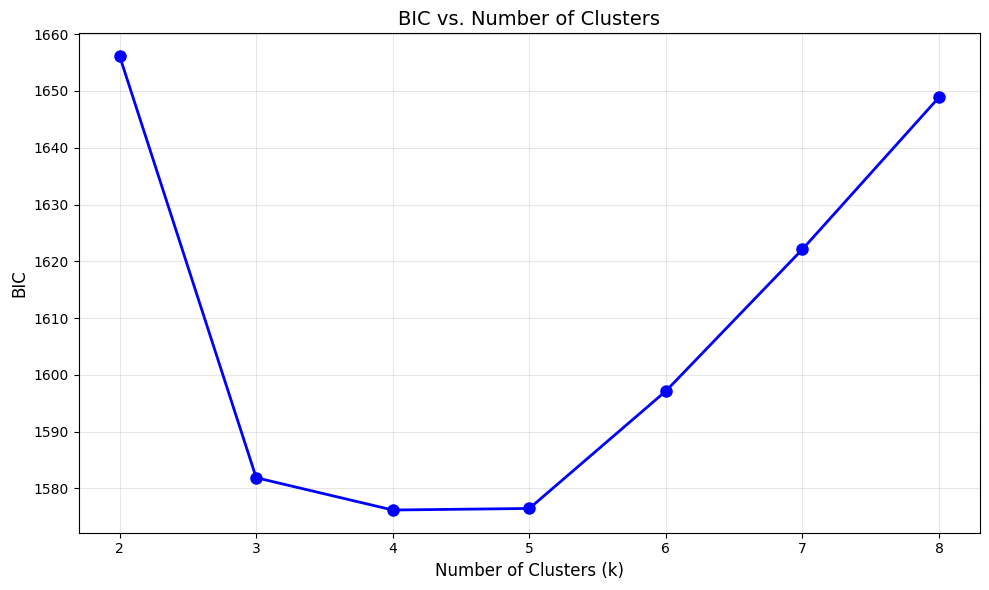

BIC plot saved!


In [116]:
# TODO: Plot BIC values to show optimal k selection
plt.figure(figsize=(10, 6))
plt.plot(list(k_range), bic_values, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('BIC', fontsize=12)
plt.title('BIC vs. Number of Clusters', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(list(k_range))
plt.tight_layout()
plt.savefig('01_BIC_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("BIC plot saved!")

## Step 6: Train Final Model

In [117]:
# TODO: Train final model with optimal k
final_weights, final_means, final_covs, final_resp, final_ll = best_models[best_k - 2]
clusters = np.argmax(final_resp, axis=1)

print(f"Final model trained with k={best_k}")
print(f"\nCluster assignments:")
for i in range(best_k):
    print(f"  Cluster {i}: {np.sum(clusters == i)} samples")

Final model trained with k=4

Cluster assignments:
  Cluster 0: 51 samples
  Cluster 1: 56 samples
  Cluster 2: 54 samples
  Cluster 3: 39 samples


## Step 7: 2D Plots with Cluster Circles and Centroids

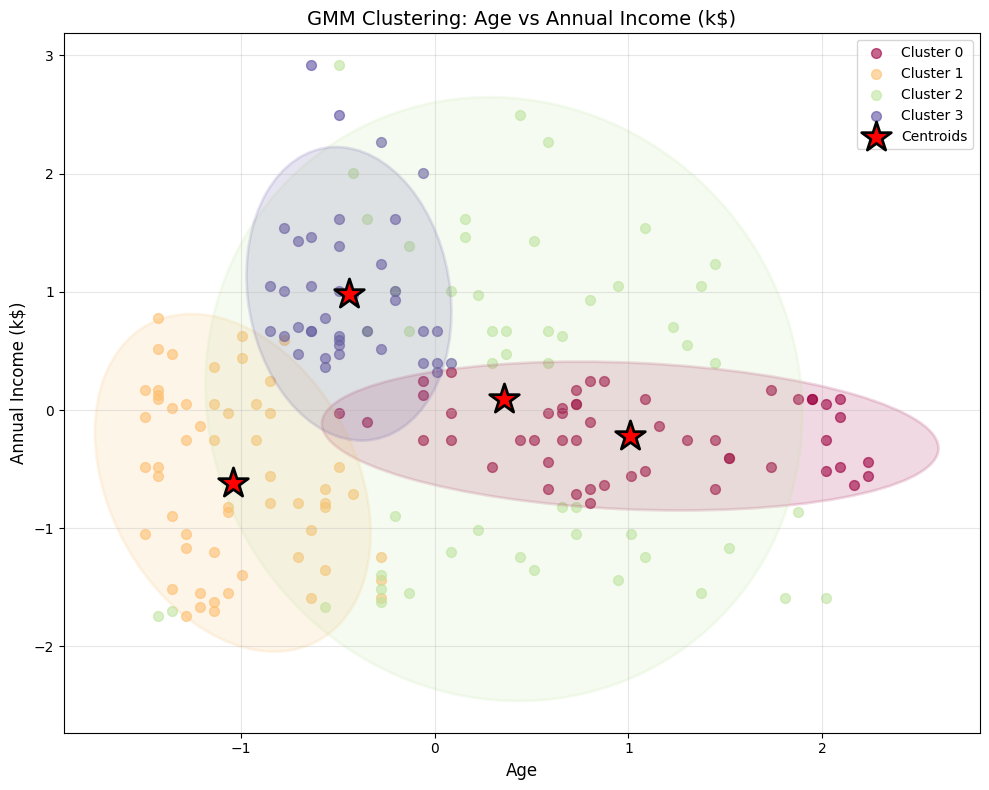

2D plot saved: 02_2D_0_1.png


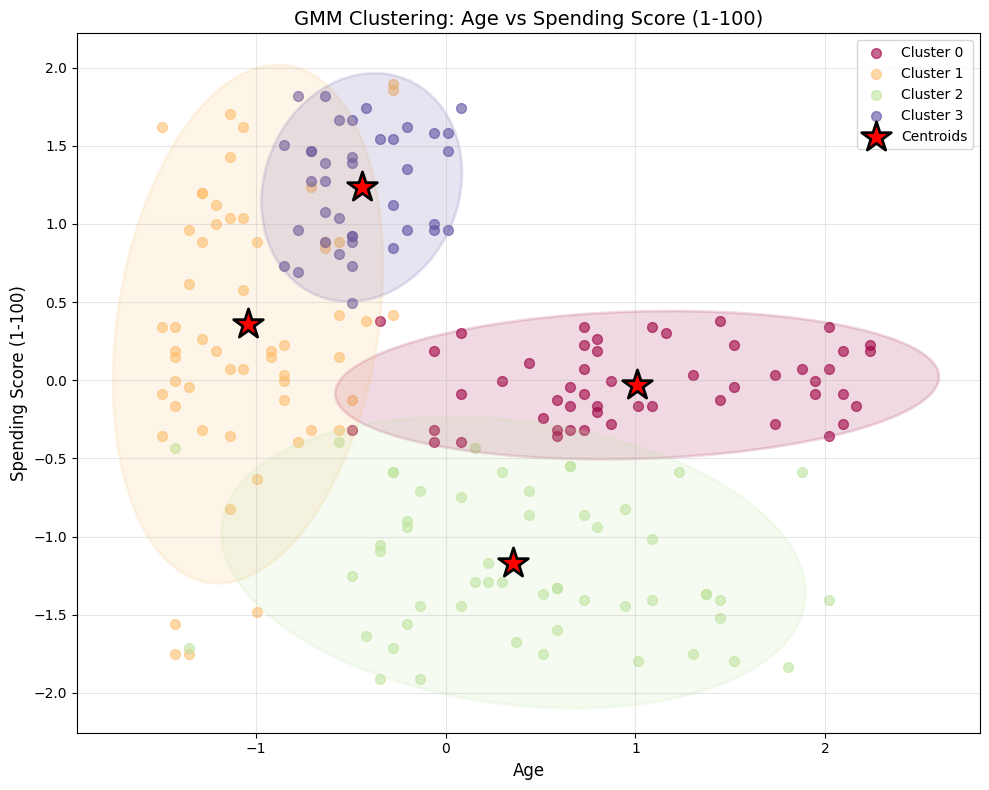

2D plot saved: 02_2D_0_2.png


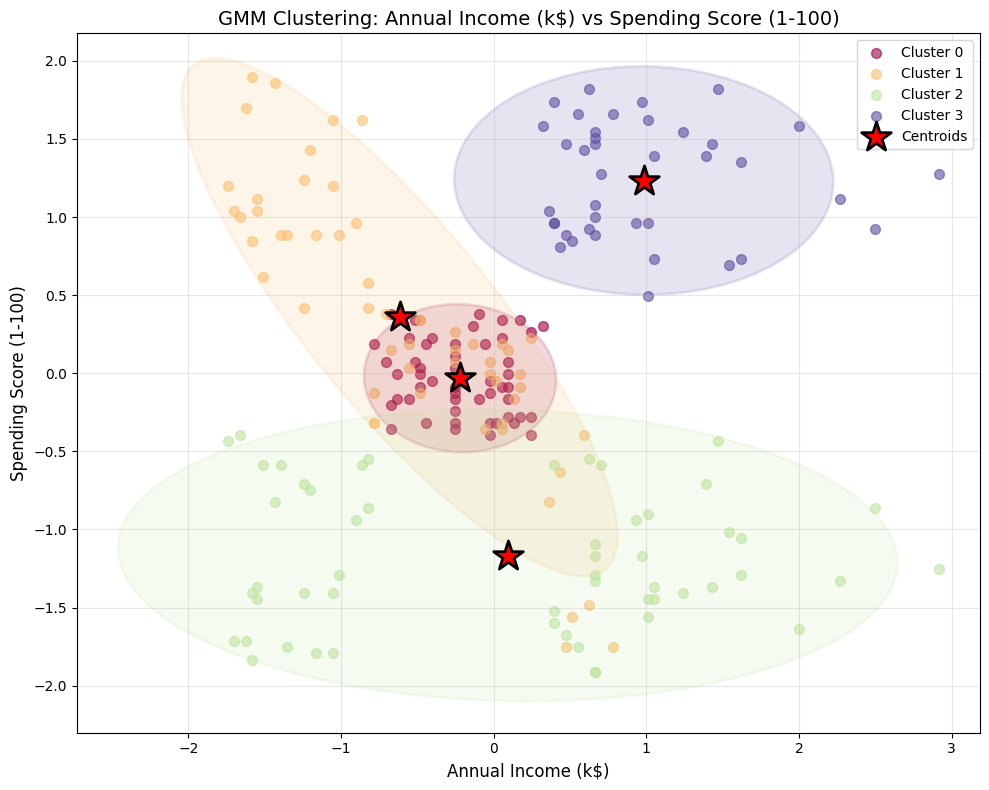

2D plot saved: 02_2D_1_2.png


In [118]:
# TODO: Create 2D scatter plots with cluster visualization
feature_pairs = [
    (0, 1, 'Age', 'Annual Income (k$)'),
    (0, 2, 'Age', 'Spending Score (1-100)'),
    (1, 2, 'Annual Income (k$)', 'Spending Score (1-100)')
]

# Instead of Set3, use:
colors = plt.cm.Set1(np.linspace(0, 1, best_k))    # Brighter
colors = plt.cm.viridis(np.linspace(0, 1, best_k)) # Purple to yellow
colors = plt.cm.rainbow(np.linspace(0, 1, best_k)) # Rainbow
colors = plt.cm.Spectral(np.linspace(0, 1, best_k)) # Red to blue
for feat_idx1, feat_idx2, feat_name1, feat_name2 in feature_pairs:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Plot samples colored by cluster
    for i in range(best_k):
        mask = clusters == i
        ax.scatter(X_scaled[mask, feat_idx1], X_scaled[mask, feat_idx2], 
                  label=f'Cluster {i}', s=50, alpha=0.6, color=colors[i])
    
    # Plot cluster means
    ax.scatter(final_means[:, feat_idx1], final_means[:, feat_idx2], 
              marker='*', s=500, c='red', edgecolors='black', linewidths=2,
              label='Centroids', zorder=5)
    
    # Draw ellipses for cluster spreads
    for i in range(best_k):
        cov_2d = np.array([[final_covs[i, feat_idx1, feat_idx1], 
                           final_covs[i, feat_idx1, feat_idx2]],
                          [final_covs[i, feat_idx2, feat_idx1], 
                           final_covs[i, feat_idx2, feat_idx2]]])
        
        eigenvalues, eigenvectors = np.linalg.eig(cov_2d)
        angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))
        
        width, height = 2 * 2 * np.sqrt(eigenvalues)  # 2-sigma
        ellipse = plt.matplotlib.patches.Ellipse(
            (final_means[i, feat_idx1], final_means[i, feat_idx2]),
            width, height, angle=angle, 
            facecolor=colors[i], alpha=0.15, edgecolor=colors[i], linewidth=2
        )
        ax.add_patch(ellipse)
    
    ax.set_xlabel(feat_name1, fontsize=12)
    ax.set_ylabel(feat_name2, fontsize=12)
    ax.set_title(f'GMM Clustering: {feat_name1} vs {feat_name2}', fontsize=14)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    filename = f'02_2D_{feat_idx1}_{feat_idx2}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"2D plot saved: {filename}")

## Step 8: 3D Plot with Cluster Centroids

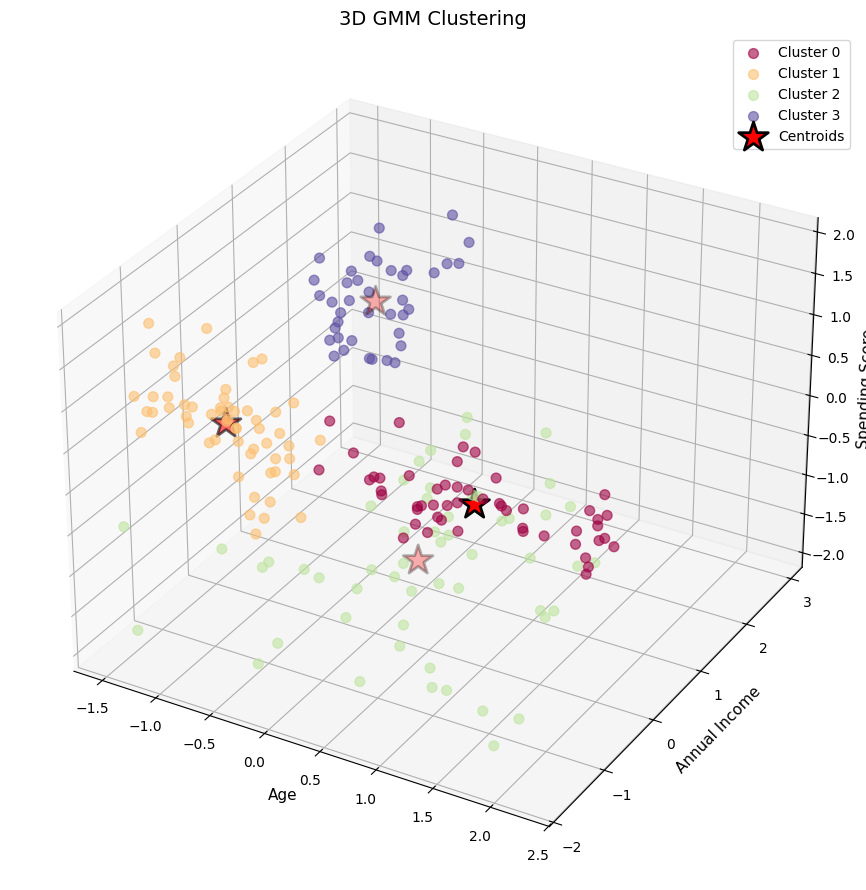

3D plot saved!


In [119]:
# TODO: Create 3D scatter plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for i in range(best_k):
    mask = clusters == i
    ax.scatter(X_scaled[mask, 0], X_scaled[mask, 1], X_scaled[mask, 2],
              label=f'Cluster {i}', s=50, alpha=0.6, color=colors[i])

# Plot centroids
ax.scatter(final_means[:, 0], final_means[:, 1], final_means[:, 2],
          marker='*', s=500, c='red', edgecolors='black', linewidths=2,
          label='Centroids', zorder=5)

ax.set_xlabel('Age', fontsize=11)
ax.set_ylabel('Annual Income', fontsize=11)
ax.set_zlabel('Spending Score', fontsize=11)
ax.set_title('3D GMM Clustering', fontsize=14)
ax.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig('03_3D_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("3D plot saved!")

## Step 9: Save Segmented Results

In [120]:
# TODO: Save customer segmentation results to CSV
df_clustered = df.copy()
df_clustered['Cluster'] = clusters

# Reorder columns to show cluster assignment
cols = ['CustomerID', 'Genre', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Cluster']
df_clustered = df_clustered[cols]

# Save to CSV
df_clustered.to_csv('customer_segmentation_results.csv', index=False)

print("Customer Segmentation Results:")
print(df_clustered.head(10))
print(f"\nTotal customers: {len(df_clustered)}")
print("\nCluster distribution:")
for i in range(best_k):
    count = np.sum(clusters == i)
    percentage = (count / len(df_clustered)) * 100
    print(f"  Cluster {i}: {count} customers ({percentage:.1f}%)")

print("\n✓ Results saved to 'customer_segmentation_results.csv'")

Customer Segmentation Results:
   CustomerID   Genre  Age  Annual Income (k$)  Spending Score (1-100)  \
0           1    Male   19                  15                      39   
1           2    Male   21                  15                      81   
2           3  Female   20                  16                       6   
3           4  Female   23                  16                      77   
4           5  Female   31                  17                      40   
5           6  Female   22                  17                      76   
6           7  Female   35                  18                       6   
7           8  Female   23                  18                      94   
8           9    Male   64                  19                       3   
9          10  Female   30                  19                      72   

   Cluster  
0        2  
1        1  
2        2  
3        1  
4        2  
5        1  
6        2  
7        1  
8        2  
9        1  

Total cust

## Summary

Your first 10 rows should look like:

| CustomerID | Genre | Age | Annual Income | Spending Score | **Cluster** |
|---|---|---|---|---|---|
| 1 | Male | 19 | 15 | 39 | **2** |
| 2 | Male | 21 | 15 | 81 | **1** |
| 3 | Female | 20 | 16 | 6 | **2** |
| 4 | Female | 23 | 16 | 77 | **1** |
| ... | ... | ... | ... | ... | **...** |